# 02. Run _scMaui_ on single-cell multiomics dataset


This tutorial explains how to run _scMaui_ on a single-cell multiomics dataset saved in .hdf5 file format. We use preprocessed dataset. For the detailed preprocessing schemes, please find it in the first [tutorial](https://github.com/BIMSBbioinfo/scmaui-experiments/blob/main/tutorials/01.%20Data%20preprocessing.ipynb). 


### Load single-cell multiomics data

_scMaui_ requires its own dataset object which can be created from _anndata_ objects. Users have to load data from .hdf5 files using _load\_data_ function. An assay name for each file needs to be given. 

From the loaded data, you can create a _SCDataset_ object. Here, you need to specify what kind of reconstruction losses for each assay and which columns in _obs_ field will be considered as batch effect factors. Here, we use negative binomial loss for both RNA and ATAC-seq assays and only different donors (DonorNumber) is assigned to an input of adversarial and conditional fields which handle batch effect correction. 

In [1]:
from scmaui.data import load_data
from scmaui.data import SCDataset
import os 

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # This line is for avoiding tensorflow models to be allocated to GPUs

adatas = load_data(["../data/GSE194122/gex_preprocessed.hdf5", 
                    "../data/GSE194122/atac_preprocessed.hdf5"], names=['gex', 'atac'])

dataset = SCDataset(adatas, losses=["negbinom", "negbinom"],
                    union=True, adversarial=["DonorNumber"],
                    conditional=["DonorNumber"])
dataset

Inputs: non-missing/samples x features
	gex: 2498/2498 x 13431
	atac: 2498/2498 x 116490
Outputs:
	gex: 2498/2498 x 13431
	atac: 2498/2498 x 116490
1 Adversarials: ['DonorNumber']
1 Conditionals: ['DonorNumber']

### Hyperparameter setup and create a scMaui model

_init\_model\_params_ function provides an initial setup of hyperparameters. You can change some hyperparameters either using _update_ method or directly assigning a value to a specific dictionary key.


In [2]:
from scmaui.utils import init_model_params

params = init_model_params()
params.update({'losses': dataset.losses})
params['kl_weight'] = 0.3

_input\_modality_ and _output\_modality_ demand assays for input and output data each. Since we would like to obtain a reduced dimensional embedding where both assays integrated together, the two assay names are given. 

_adversarial\_config_ and _conditional\_config_ methods of _SCDataset_ automatically update all hyperparameters related to batch effect handling.

In [3]:
modalities = dataset.modalities()
params['input_modality'] = modalities[0]
params['output_modality'] = modalities[1]
params.update(dataset.adversarial_config())
params.update(dataset.conditional_config())

This is the final hyperparameter setup for running scMaui.

In [4]:
params

OrderedDict([('nunits_encoder', 32),
             ('nlayers_encoder', 5),
             ('nunits_decoder', 20),
             ('nlayers_decoder', 1),
             ('dropout_input', 0.1),
             ('dropout_encoder', 0.0),
             ('dropout_decoder', 0.0),
             ('nunits_adversary', 128),
             ('nlayers_adversary', 2),
             ('kl_weight', 0.3),
             ('nlatent', 10),
             ('nmixcomp', 1),
             ('losses', ['negbinom', 'negbinom']),
             ('input_modality', ['gex', 'atac']),
             ('output_modality', ['gex', 'atac']),
             ('adversarial_name', ['DonorNumber']),
             ('adversarial_dim', [2]),
             ('adversarial_type', ['category']),
             ('conditional_name', ['DonorNumber']),
             ('conditional_dim', [2]),
             ('conditional_type', ['category'])])

You can create a _scMaui_ model with the hyperparameter set. _ensemble\_size_ decides the number of models for ensemble learning. More number of models will make more converged and credible results. However, we here set 1 as the ensemble size. 

In [5]:
from scmaui.ensembles import EnsembleVAE

ensemble = EnsembleVAE(params=params, ensemble_size=1)

using vae


### Run _scMaui_

_scMaui_ uses _fit_ method to train the model. Different number of epochs, learning rate and batch size can be given. Users have to provide an _SCDataset_ object.

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # This line disables Tensorflow debugging information
train_loss = ensemble.fit(dataset, epochs=100, 
                          learning_rate=0.001, batch_size=128)

Run model 1
Epoch 1/100
17/17 - 16s - adv: 179.7237 - kl: 389.2190 - recon: 47600.1444 - loss: 47809.6407 - val_adv: 56.1183 - val_kl: 1372.6075 - val_recon: 14849.9727 - val_loss: 16166.4619
Epoch 2/100
17/17 - 14s - adv: 196.0416 - kl: 1911.7233 - recon: 13301.5289 - loss: 15017.2107 - val_adv: 55.2990 - val_kl: 1669.7369 - val_recon: 12555.9902 - val_loss: 14170.4287
Epoch 3/100
17/17 - 14s - adv: 209.2327 - kl: 1060.3217 - recon: 11588.0059 - loss: 12439.0950 - val_adv: 63.6493 - val_kl: 689.1550 - val_recon: 11682.4268 - val_loss: 12307.9326
Epoch 4/100
17/17 - 14s - adv: 168.3025 - kl: 624.3598 - recon: 11181.2721 - loss: 11637.3294 - val_adv: 83.3239 - val_kl: 567.4203 - val_recon: 11469.5283 - val_loss: 11953.6240
Epoch 5/100
17/17 - 15s - adv: 171.8524 - kl: 531.8191 - recon: 10966.0745 - loss: 11326.0410 - val_adv: 69.5707 - val_kl: 484.0771 - val_recon: 11298.1631 - val_loss: 11712.6699
Epoch 6/100
17/17 - 15s - adv: 150.1731 - kl: 472.6309 - recon: 10790.7470 - loss: 11113.

Epoch 47/100
17/17 - 14s - adv: 139.6656 - kl: 103.0390 - recon: 9994.9650 - loss: 9958.3383 - val_adv: 49.5125 - val_kl: 82.0760 - val_recon: 10592.1270 - val_loss: 10624.6904
Epoch 48/100
17/17 - 15s - adv: 136.4964 - kl: 100.3732 - recon: 9975.5249 - loss: 9939.4017 - val_adv: 48.9306 - val_kl: 79.6542 - val_recon: 10595.7881 - val_loss: 10626.5117
Epoch 49/100
17/17 - 15s - adv: 146.8350 - kl: 98.3726 - recon: 9979.7999 - loss: 9931.3376 - val_adv: 54.6785 - val_kl: 77.7585 - val_recon: 10586.9072 - val_loss: 10609.9873
Epoch 50/100
17/17 - 15s - adv: 149.6419 - kl: 96.7933 - recon: 9968.9113 - loss: 9916.0626 - val_adv: 53.1683 - val_kl: 77.2196 - val_recon: 10584.7803 - val_loss: 10608.8320
Epoch 51/100
17/17 - 14s - adv: 145.9594 - kl: 95.2637 - recon: 9969.1606 - loss: 9918.4650 - val_adv: 63.1248 - val_kl: 76.8234 - val_recon: 10573.9912 - val_loss: 10587.6895
Epoch 52/100
17/17 - 15s - adv: 140.7236 - kl: 94.5494 - recon: 9967.0828 - loss: 9920.9086 - val_adv: 54.1642 - val_k

Epoch 94/100
17/17 - 14s - adv: 154.3652 - kl: 67.3105 - recon: 9764.7603 - loss: 9677.7056 - val_adv: 80.2274 - val_kl: 51.6063 - val_recon: 10427.9600 - val_loss: 10399.3389
Epoch 95/100
17/17 - 14s - adv: 166.7458 - kl: 67.7155 - recon: 9731.3388 - loss: 9632.3083 - val_adv: 67.7399 - val_kl: 51.3894 - val_recon: 10431.6445 - val_loss: 10415.2939
Epoch 96/100
17/17 - 14s - adv: 174.8360 - kl: 67.0020 - recon: 9734.8209 - loss: 9626.9870 - val_adv: 63.0581 - val_kl: 50.3867 - val_recon: 10436.3369 - val_loss: 10423.6660
Epoch 97/100
17/17 - 14s - adv: 171.8222 - kl: 67.1495 - recon: 9728.2677 - loss: 9623.5951 - val_adv: 62.1575 - val_kl: 50.1863 - val_recon: 10424.7510 - val_loss: 10412.7803
Epoch 98/100
17/17 - 15s - adv: 157.5203 - kl: 66.1071 - recon: 9753.6440 - loss: 9662.2308 - val_adv: 59.3675 - val_kl: 50.0491 - val_recon: 10427.4326 - val_loss: 10418.1143
Epoch 99/100
17/17 - 14s - adv: 147.9530 - kl: 65.9289 - recon: 9751.4836 - loss: 9669.4595 - val_adv: 53.7512 - val_kl:

Once the training is done, _tensorflow_ [_CSVLogger_](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger) callback object is returned. This contains the loss history over epochs and save the information in a .csv file.

You can plot different loss values over epochs as follows:

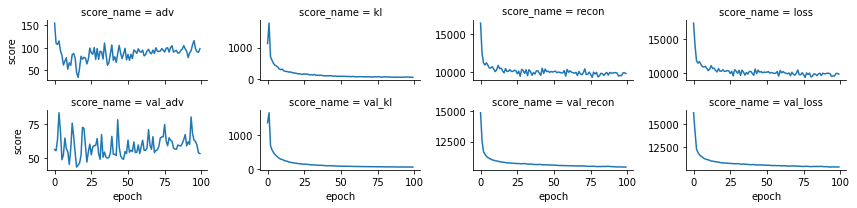

In [10]:
import pandas as pd
import seaborn as sns
train_history = [pd.DataFrame({"score":train_loss[0].history[k], 
                               "score_name":[k] * len(train_loss[0].history[k]),
                               "epoch":range(len(train_loss[0].history[k]))}) \
                for k in train_loss[0].history.keys()]
train_history = pd.concat(train_history)
g = sns.FacetGrid(train_history, col="score_name", sharey=False, height=1.5, aspect=2, col_wrap=4)
g.map_dataframe(sns.lineplot, x="epoch", y="score")

### Generate latents from the trained _scMaui_ model

_scMaui_ model has a method called _encode_ which generates latents from itself for the given dataset. We obtained 10 latents as spcified in the hyperparameter set. For a larger dataset (with more cells and/or more feature), please increase _n\_latent_ value and _epochs_ to catch more detailed heterogeneity.

In [11]:
latent, latent_list = ensemble.encode(dataset)
latent

,D0-0,D0-1,D0-2,D0-3,D0-4,D0-5,D0-6,D0-7,D0-8,D0-9
TTACCTGTCTATGACA-1-s1d1,-9.838795,6.195411,8.335258,-3.586614,6.346725,14.169819,-22.856667,19.110653,6.055818,-4.629482
GGCAATCGTTAGGACC-1-s1d1,-12.707518,-11.215344,6.360462,-10.231348,7.159553,8.075758,-2.361437,1.759270,-5.707277,-10.614829
AATTTGCCATAATGAG-1-s1d1,-7.188019,0.210785,10.715696,-3.690795,2.816586,4.736997,-7.749164,14.892978,3.809777,-1.341578
AGTTATGTCTCACTCA-1-s1d1,-10.959953,-11.328440,6.579100,-9.139611,5.117791,11.148275,-2.794507,1.759448,-10.073934,-14.479380
TGTATCGCAGCTCATA-1-s1d1,-4.451385,6.220009,7.512424,-2.282693,6.665693,24.351288,-15.849043,8.615520,3.849029,-11.988990
...,...,...,...,...,...,...,...,...,...,...
CCGTTATGTGTCCAGG-2-s1d2,2.105067,-6.259311,5.011844,-0.888337,6.122257,1.521568,1.002180,10.716655,0.251841,-3.049025
GTGAACAAGCAAGACA-2-s1d2,2.216995,-5.723575,7.148350,-1.796773,4.640602,3.922538,0.688249,6.890374,1.134394,-4.790414
TCCTTCAAGTTGGCCA-2-s1d2,2.560553,-3.389651,7.793463,-2.897735,5.657646,3.961449,-0.097573,7.388779,1.552284,-3.186393
TATTAGCCAATTGAGA-2-s1d2,3.256564,-7.142349,12.350916,-2.486266,1.340397,2.542015,0.357934,5.935097,4.182960,-4.289228


In [12]:
latent.to_csv("../data/GSE194122/scmaui_latents.csv", sep="\t", index=True)